# Image Clustering Analysis
this overall function will do below
1. Data Loading and Cleaning: Load the images, put the url into a variable that i can set later on, resize and normalized
2. Feature Extraction: Convert the cleaned text into numerical features using your proposed method.
3. Optimal Cluster Determination: Use the Elbow Method and Silhouette Score to determine the optimal number of clusters. The optimal number of clusters is determined based on the highest silhouette score.
4. Clustering: Perform clustering using K-Means with the optimal number of clusters.
5. Print Cluster Content: Print the content of each cluster, including the number of members in each cluster.
6. PCA Scatter Plot: Visualize the clusters using a 2D scatter plot with PCA.
7. prepare the output to a list object in python

## Preparing modules

In [6]:
import pandas as pd
import numpy as np
import requests
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from urllib.parse import urlsplit, urlunsplit
import data_connector

# Step 1: Data Loading and Cleaning
def load_image(url, url_prefix, size=(512, 512)):
    # Remove the filename extension
    parts = list(urlsplit(url))
    path = parts[2]
    path = '/'.join(part.rsplit('.', 1)[0] for part in path.split('/'))
    parts[2] = path
    url = urlunsplit(parts)

    # Add the URL prefix
    full_url = url_prefix + url
    print(full_url)

    response = requests.get(full_url)
    img = Image.open(BytesIO(response.content))
    img = img.resize(size)
    img = np.array(img)
    if img.shape[2] == 4:
        img = img[:, :, :3]  # Remove alpha channel if present
    img = img / 255.0  # Normalize
    return img

# Step 2: Feature Extraction
def extract_features(img):
    h, w, c = img.shape
    return img.reshape(1, h * w * c)

# Main function to execute the steps
def main(df, url_column, url_prefix):
    all_features = []
    for url in df[url_column]:
        img = load_image(url, url_prefix)
        features = extract_features(img)
        all_features.append(features)
    all_features = np.vstack(all_features)

    # Determine optimal clusters
    optimal_clusters, inertia, silhouette_scores = determine_optimal_clusters(all_features)
    if optimal_clusters is None:
        print("Could not determine optimal clusters due to insufficient unique labels.")
        return []
    
    cluster_labels, kmeans = perform_clustering(all_features, optimal_clusters)
    print_cluster_content(cluster_labels)
    pca_result = visualize_clusters(all_features, cluster_labels)
    output = prepare_output(cluster_labels, pca_result, all_features)
    return output

# Step 3: Optimal Cluster Determination
def determine_optimal_clusters(features):
    inertia = []
    silhouette_scores = []
    range_n_clusters = list(range(2, min(10, len(features))))
    for n_clusters in range_n_clusters:
        kmeans = KMeans(n_clusters=n_clusters)
        cluster_labels = kmeans.fit_predict(features)
        inertia.append(kmeans.inertia_)
        if len(np.unique(cluster_labels)) > 1:
            silhouette_scores.append(silhouette_score(features, cluster_labels))
        else:
            silhouette_scores.append(-1)
    
    if all(score == -1 for score in silhouette_scores):
        return None, inertia, silhouette_scores
    
    optimal_clusters = range_n_clusters[np.argmax(silhouette_scores)]
    return optimal_clusters, inertia, silhouette_scores

# Step 4: Clustering
def perform_clustering(features, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters)
    cluster_labels = kmeans.fit_predict(features)
    return cluster_labels, kmeans

# Step 5: Print Cluster Content
def print_cluster_content(cluster_labels):
    unique_labels = np.unique(cluster_labels)
    for label in unique_labels:
        print(f"Cluster {label}: {np.sum(cluster_labels == label)} members")

# Step 6: PCA Scatter Plot
def visualize_clusters(features, cluster_labels):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(features)
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=cluster_labels, cmap='viridis')
    plt.colorbar(scatter)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('Clusters Visualization with PCA')
    plt.show()
    return pca_result

# Step 7: Prepare Output
def prepare_output(cluster_labels, pca_result, features):
    output = []
    unique_labels = np.unique(cluster_labels)
    for label in unique_labels:
        members = np.where(cluster_labels == label)[0].tolist()
        cluster_pca1 = pca_result[cluster_labels == label, 0].tolist()
        cluster_pca2 = pca_result[cluster_labels == label, 1].tolist()
        cluster_features = features[cluster_labels == label]
        if len(np.unique(cluster_labels)) > 1:
            similarity_score = silhouette_score(cluster_features, [label] * len(cluster_features))
        else:
            similarity_score = -1
        output.append({
            'cluster': label,
            'members': members,
            'pca1': cluster_pca1,
            'pca2': cluster_pca2,
            'similarity_score': similarity_score
        })
    
    # Convert to DataFrame
    df_output = pd.DataFrame(output)
    
    # Convert DataFrame to list
    list_output = df_output.to_numpy().tolist()
    
    return list_output


## Main function to execute the steps

## 1. Query Jobs data from server and mark the jobs

In [2]:
strSQL = """
select 	a.id as jobsid,
        a.*,
		c.id as key_monitoring_media_social, 
		d.id as key_monitoring_media_online,
		c.*
from 	screen_analisis_ai a 
		inner join monitoring_search b
			on cast(a.monitoring_id as varchar) = cast(b.id as varchar)
		inner join monitoring_media_social c
			on b.id = c.monitoring_search_id 
		left outer join  monitoring_media_online d
			on d.monitoring_search_id = c.monitoring_search_id 
where a.jenis_analisa = '20'
and a.status = 1
order by a.created desc 
limit 1
"""

strSQL = """
select 	a.id as jobsid,
        a.*,
		c.id as key_monitoring_media_social, 
		d.id as key_monitoring_media_online,
		c.*
from 	screen_analisis_ai a 
		inner join monitoring_search b
			on cast(a.monitoring_id as varchar) = cast(b.id as varchar)
		inner join monitoring_media_social c
			on b.id = c.monitoring_search_id 
		left outer join  monitoring_media_online d
			on d.monitoring_search_id = c.monitoring_search_id 
where a.jenis_analisa = '20'
		and a.id = 5057
"""


df_job = data_connector.execute_query_psql(strSQL)
if len(df_job) == 0:
    # get out, nothing to do
    print('Zero jobs, quitting now')
    quit()
    
similarity_treshold = 0.9
i_process_id = df_job['jobsid'][0]
screen_name = ''
database_keyword_id = df_job['key_monitoring_media_social'][0]
social_media_monitoring_id = df_job['key_monitoring_media_social'][0]
media_online_monitoring_id = df_job['key_monitoring_media_online'][0]

# print(database_keyword_id)
print(similarity_treshold)
print(i_process_id)
print(social_media_monitoring_id)
print(media_online_monitoring_id)


# # Prepare SQL Statement
# print(i_process_id)
# sql = "update screen_analisis_ai set status = 2, last_status_update = now(), start_process = now() where id = %s"
# sql = sql.replace('%s', str(i_process_id))

# print(sql)
# row_count = data_connector.execute_query_psql(sql)
# print('update ' + str(row_count) + ' rows')

# # Create Header Record
# sql = "insert into ret_analysis_header (job_id, datetime_start, user_id) values (%s, now(), %s)" % (i_process_id,"1")
# # Execute the query
# data_connector.execute_query_psql(sql)



0.9
5057
5137a67b-0145-4e81-a623-a6ce9fad64d1
None


## 2. Iterate through the result

In [7]:
ssql = """
select 	a.id as key_id,
        b.filename as filename
from 	tiktok a inner join media_files_tiktok b 
        on a.id = b.tiktok_id 
where a.monitoring_id = '%s'
"""
ssql = ssql % (social_media_monitoring_id)
print(ssql)

img_prefix_http = "https://disestages.com/api/media/photo/download/tiktok/"

result_df = data_connector.execute_query_psql(ssql)


select 	a.id as key_id,
        b.filename as filename
from 	tiktok a inner join media_files_tiktok b 
        on a.id = b.tiktok_id 
where a.monitoring_id = '5137a67b-0145-4e81-a623-a6ce9fad64d1'



In [4]:
result_df.head()

,key_id,filename
0,7365797784676502790,7365797784676502790.jpg
1,7352001532558118150,7352001532558118150.jpg
2,7368438560145411334,7368438560145411334.jpg
3,7363875416085499142,7363875416085499142.jpg
4,7372448077837241605,7372448077837241605.jpg


https://disestages.com/api/media/photo/download/tiktok/7365797784676502790
https://disestages.com/api/media/photo/download/tiktok/7352001532558118150
https://disestages.com/api/media/photo/download/tiktok/7368438560145411334
https://disestages.com/api/media/photo/download/tiktok/7363875416085499142
https://disestages.com/api/media/photo/download/tiktok/7372448077837241605
https://disestages.com/api/media/photo/download/tiktok/7284595287572630789
https://disestages.com/api/media/photo/download/tiktok/7277972367983332614
https://disestages.com/api/media/photo/download/tiktok/7221524795240779035
https://disestages.com/api/media/photo/download/tiktok/7369075478419754245
https://disestages.com/api/media/photo/download/tiktok/7365414716484701446
https://disestages.com/api/media/photo/download/tiktok/7363623784647019781
https://disestages.com/api/media/photo/download/tiktok/7364028421007183109
https://disestages.com/api/media/photo/download/tiktok/7348365396791020806
https://disestages.com/ap

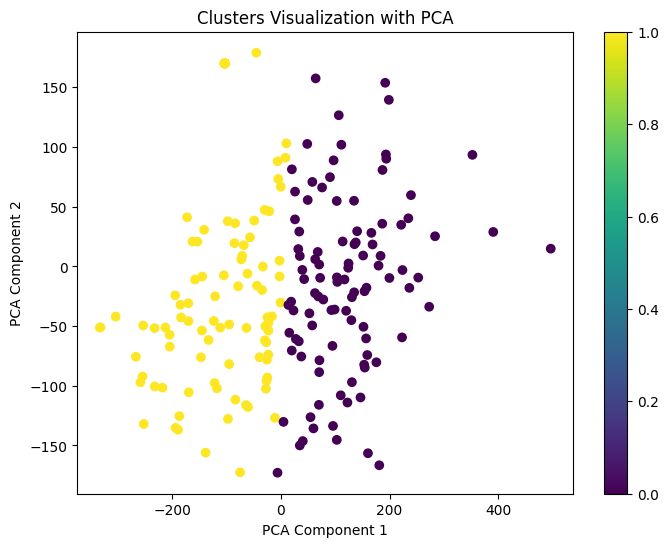

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [8]:
# # Example usage
# data = {
#     'url': [
#         'https://example.com/image1.jpg',
#         'https://example.com/image2.jpg',
#         # Add more image URLs here
#     ]
# }

output = main(result_df, 'filename', img_prefix_http)
# print(output)